# Stock Price Prediction with LSTM and Comparative Analysis
**Dataset:** AMD historical daily prices

This notebook builds on the previous version by adding:
- Comparative baseline (naïve persistence)
- Ablation study over sequence length and hidden units
- Computational complexity stats (parameter count & training time)
- Clear presentation of results via tables and figures
- Discussion on over‑/under‑fitting and mitigation strategies

---

In [1]:

import pandas as pd, numpy as np, os, math, time, itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
plt.rcParams['figure.figsize']=(12,6)


In [2]:

DATA_PATH='AMD.csv'  # adjust path as needed
assert os.path.exists(DATA_PATH), "CSV not found"
df=pd.read_csv(DATA_PATH, parse_dates=['Date']).sort_values('Date')


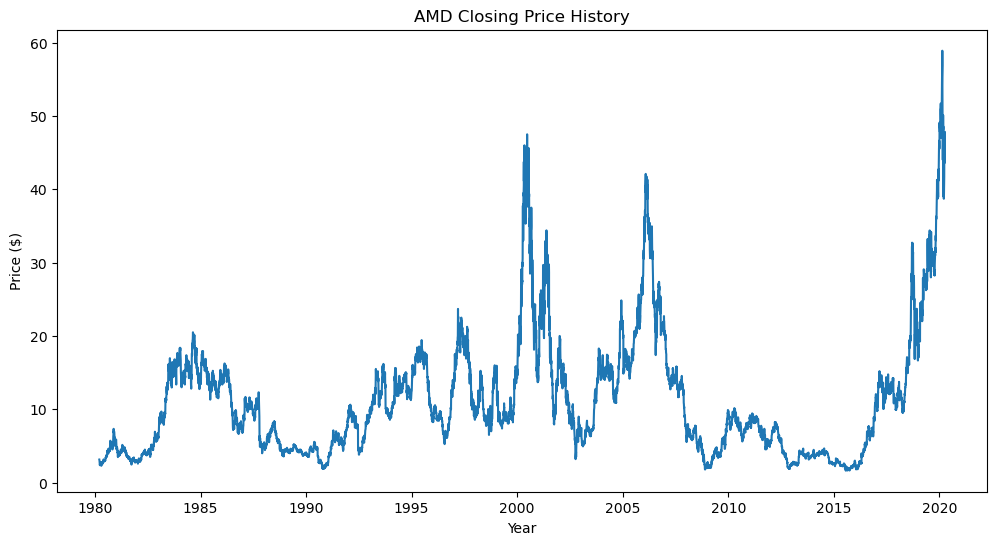

In [3]:

plt.plot(df['Date'], df['Close'])
plt.title('AMD Closing Price History')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show()


In [4]:

def create_sequences(array, seq_len):
    x,y=[],[]
    for i in range(seq_len, len(array)):
        x.append(array[i-seq_len:i,0])
        y.append(array[i,0])
    return np.array(x), np.array(y)

def build_lstm(seq_len, units):
    model=Sequential([
        LSTM(units, return_sequences=True, input_shape=(seq_len,1)),
        Dropout(0.2),
        LSTM(units),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [5]:

close_vals=df[['Close']].values
train_size=int(len(close_vals)*0.8)
y_actual=close_vals[train_size:]
y_pred_persist=close_vals[train_size-1:-1]
rmse_persist=math.sqrt(mean_squared_error(y_actual,y_pred_persist))
mae_persist=mean_absolute_error(y_actual,y_pred_persist)
print(f"Persistence baseline -> RMSE:{rmse_persist:.4f} MAE:{mae_persist:.4f}")


Persistence baseline -> RMSE:0.6219 MAE:0.2920


## Default LSTM model (seq_len=60, units=50)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


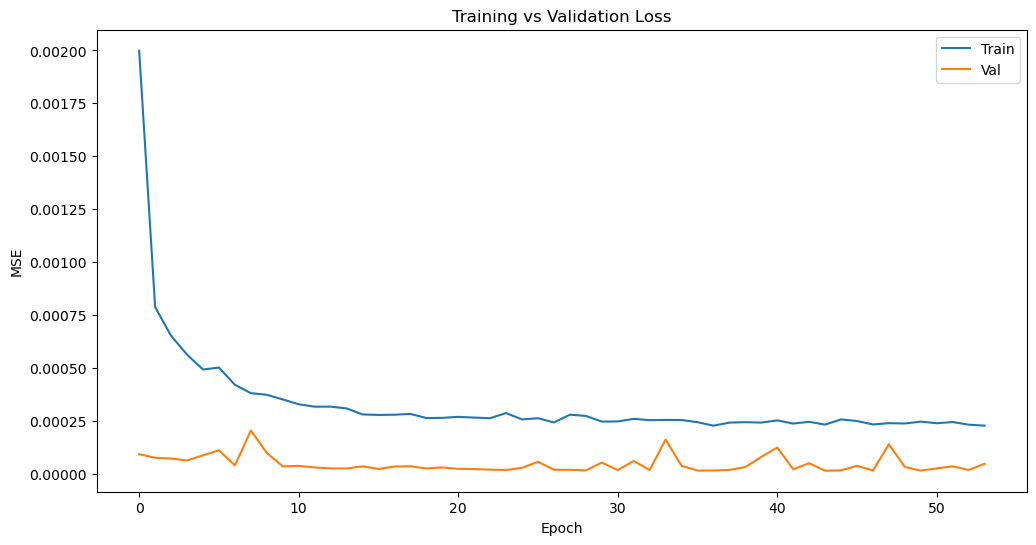

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LSTM RMSE:0.7685  MAE:0.3667


In [6]:

SEQ_LEN=60
UNITS=50
scaler=MinMaxScaler()
scaled=scaler.fit_transform(close_vals)
X,y=create_sequences(scaled, SEQ_LEN)
X=X.reshape((X.shape[0],X.shape[1],1))
split=int(0.8*len(X))
X_train,X_test=X[:split],X[split:]
y_train,y_test=y[:split],y[split:]

model=build_lstm(SEQ_LEN,UNITS)
es=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
start=time.time()
hist=model.fit(X_train,y_train,validation_split=0.1,epochs=100,batch_size=32,callbacks=[es],verbose=0)
train_time=time.time()-start

# Training loss plot
plt.plot(hist.history['loss'],label='Train')
plt.plot(hist.history['val_loss'],label='Val')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Evaluate
pred=model.predict(X_test)
pred_inv=scaler.inverse_transform(pred)
y_test_inv=scaler.inverse_transform(y_test.reshape(-1,1))
rmse_lstm=math.sqrt(mean_squared_error(y_test_inv,pred_inv))
mae_lstm=mean_absolute_error(y_test_inv,pred_inv)
print(f'LSTM RMSE:{rmse_lstm:.4f}  MAE:{mae_lstm:.4f}')



### Overfitting / Underfitting Analysis
"
Compare the training and validation loss curves above:
"
- If validation loss diverges upward while training loss keeps decreasing, over‑fitting is present.
"
- If both curves plateau at high loss and do not improve, the model is under‑fitting.
"

"
**Mitigations** (for over‑fitting): early stopping (already used), dropout (already used), more data, simpler model, stronger regularization.
"


## Ablation Study